In [1]:
# Load libraries

# # Plotting utils 
import datetime
import glob
import os
import pickle
import time
import warnings
from datetime import date, timedelta
import Ngl
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util
import matplotlib as matplotlib
import matplotlib.animation as animation
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import metpy.calc as mpc
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import xarray as xr
from matplotlib.dates import DateFormatter
from metpy.units import units
from metpy import interpolate
from mpl_toolkits.axes_grid1 import make_axes_locatable

from joblib import Parallel, delayed

warnings.filterwarnings('ignore')


### Useful functions

In [2]:
# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds

In [3]:
def interpolateToPressure_v2(DS, varName, pressGoals):
#     nCases = len(DSin.case.values)
#     nTimes = len(DSin.time.values)
    
#     saveOut = np.full([nTimes,len(pressGoals),1,1], np.nan)

    ## For the larger arrays, need to operate case-by-case; input to vinth2p can only be 3 or 4 dimensions. 
#     for iCase in range(nCases): 
#     DS = DSin

    p0mb = DS.P0.values/100        # mb

    # Pull out hya/hyb profiles 
    hyam = np.squeeze(DS.hyam.values)[:]
    hybm = np.squeeze(DS.hybm.values)[:]
    hyai = np.squeeze(DS.hyai.values)[:]
    hybi = np.squeeze(DS.hybi.values)[:]

    # Surface pressure with time dimension
    PS   = DS.PS.values              # Pa 

    # Converting variables: 
    if np.shape(DS[varName].values)[1]==len(DS.ilev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyai,hybi,pressGoals,PS,1,p0mb,1,True)
    elif np.shape(DS[varName].values)[1]==len(DS.lev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)
    ## Handle data that's by-plume for EDMF output
    elif np.shape(DS[varName].values)[1]==len(DS.nens.values):
        varInterp = np.full([len(DS.time.values), len(DS.nens.values) ,
                             len(pressGoals), len(DS.lat.values), len(DS.lon.values)], np.nan)
        
        for iEns in range(len(DS.nens.values)):
            varInterp[:,iEns,:,:,:] = Ngl.vinth2p(DS[varName].values[:,iEns,:,:,:],hyai,hybi,pressGoals,PS,1,p0mb,1,True)

    saveOut = varInterp
    
    return saveOut

In [4]:
def interpolateToPressure_v2_h2(DS, DSctrl, varName, pressGoals):
#     nCases = len(DSin.case.values)
#     nTimes = len(DSin.time.values)
    
#     saveOut = np.full([nTimes,len(pressGoals),1,1], np.nan)

    ## For the larger arrays, need to operate case-by-case; input to vinth2p can only be 3 or 4 dimensions. 
#     for iCase in range(nCases): 
#     DS = DSin

    p0mb = DSctrl.P0.values/100        # mb

    # Pull out hya/hyb profiles 
    hyam = np.squeeze(DSctrl.hyam.values)[:]
    hybm = np.squeeze(DSctrl.hybm.values)[:]
    hyai = np.squeeze(DSctrl.hyai.values)[:]
    hybi = np.squeeze(DSctrl.hybi.values)[:]

    # Surface pressure with time dimension
    PS   = DSctrl.PS.values              # Pa 

    # Converting variables: 
    if np.shape(DS[varName].values)[1]==len(DS.ilev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyai,hybi,pressGoals,PS,1,p0mb,1,True)
    elif np.shape(DS[varName].values)[1]==len(DS.lev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)
    ## Handle data that's by-plume for EDMF output
    elif np.shape(DS[varName].values)[1]==len(DS.nens.values):
        varInterp = np.full([len(DS.time.values), len(DS.nens.values) ,
                             len(pressGoals), len(DS.lat.values), len(DS.lon.values)], np.nan)
        
        for iEns in range(len(DS.nens.values)):
            varInterp[:,iEns,:,:,:] = Ngl.vinth2p(DS[varName].values[:,iEns,:,:,:],hyai,hybi,pressGoals,PS,1,p0mb,1,True)

    saveOut = varInterp
    
    return saveOut

## Just select the cases

In [5]:
caseDir   = '/project/amp/mdfowler/cases/'

caseStart = 'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_'

caseNames = ['usePatchDataFALSE_setSfcFlxFALSE_testMergeFeb27_testInit.LASSO_20180605',
             'usePatchDataTRUE_setSfcFlxFALSE_pblhOscillations002.LASSO_20180605',
             'usePatchDataFALSE_setSfcFlxFALSE_testMergeFeb27_testInit_coldStartOn.LASSO_20180605',
             'usePatchDataTRUE_setSfcFlxFALSE_clmInit_latestMergeMar1_clmColdStartOn.LASSO_20180605', 
                         ]

shortNames = ['clubb_initOn', 
              'clasp_initOn',
              'clubb_initOff',
              'clasp_initOff',
              ]

for iCase in range(len(caseNames)):
    ## Get list of files 
    listFiles_h0 = np.sort(glob.glob(caseDir+caseStart+caseNames[iCase]+'/run/atm/hist/*cam.h0*'))
    listFiles_h1 = np.sort(glob.glob(caseDir+caseStart+caseNames[iCase]+'/run/atm/hist/*cam.h1*'))
    listFiles_h2 = np.sort(glob.glob(caseDir+caseStart+caseNames[iCase]+'/run/atm/hist/*cam.h2*'))
    listFiles_h3 = np.sort(glob.glob(caseDir+caseStart+caseNames[iCase]+'/run/atm/hist/*cam.h3*'))

    listFilesCLM_h1 = np.sort(glob.glob(caseDir+caseStart+caseNames[iCase]+'/run/lnd/hist/*clm2.h1*'))
    listFilesCLM_h0 = np.sort(glob.glob(caseDir+caseStart+caseNames[iCase]+'/run/lnd/hist/*clm2.h0*')) 
    
    ## Open files 
    case_h0 = xr.open_dataset(listFiles_h0[0], decode_times=False)
    case_h0 = cesm_correct_time(case_h0)
    
    case_h1 = xr.open_dataset(listFiles_h1[0], decode_times=False)
    case_h1 = cesm_correct_time(case_h1)
    
    case_h2 = xr.open_dataset(listFiles_h2[0], decode_times=False)
    case_h2 = cesm_correct_time(case_h2)
    
    case_h3 = xr.open_dataset(listFiles_h3[0], decode_times=False)
    case_h3 = cesm_correct_time(case_h3)
    
    caseCLM_h0 = xr.open_dataset(listFilesCLM_h0[0], decode_times=True)
    
    caseCLM_h1 = xr.open_dataset(listFilesCLM_h1[0], decode_times=True)


#     caseFull        = xr.merge([case_h1, case_h0])
    case_h2  = case_h2.assign_coords({"nens": np.arange(10)})
    case_h3  = case_h3.assign_coords({"nens": np.arange(10)})

    ## Combine all the cases into one array
    case_h0    = case_h0.assign_coords({"case":  shortNames[iCase]})
    case_h1    = case_h1.assign_coords({"case":  shortNames[iCase]})
    case_h2    = case_h2.assign_coords({"case":  shortNames[iCase]})
    case_h3    = case_h3.assign_coords({"case":  shortNames[iCase]})
    
    caseCLM_h0    = caseCLM_h0.assign_coords({"case":  shortNames[iCase]})
    caseCLM_h1    = caseCLM_h1.assign_coords({"case":  shortNames[iCase]})

    if iCase==0:
        all_h0    = case_h0
        all_h1    = case_h1
        all_h2    = case_h2
        all_h3    = case_h3
        
        allCLM_h0 = caseCLM_h0
        allCLM_h1 = caseCLM_h1
    else: 
        all_h0    = xr.concat([all_h0, case_h0], "case") 
        all_h1    = xr.concat([all_h1, case_h1], "case") 
        all_h2    = xr.concat([all_h2, case_h2], "case") 
        all_h3    = xr.concat([all_h3, case_h3], "case") 
        
        allCLM_h0    = xr.concat([allCLM_h0, caseCLM_h0], "case") 
        allCLM_h1    = xr.concat([allCLM_h1, caseCLM_h1], "case") 

    print('Done with case ', shortNames[iCase])

Done with case  clubb_initOn
Done with case  clasp_initOn
Done with case  clubb_initOff
Done with case  clasp_initOff


In [6]:
## Get more useful time index
all_h0['time'] = all_h0.indexes['time'].to_datetimeindex() 
all_h1['time'] = all_h1.indexes['time'].to_datetimeindex() 
all_h2['time'] = all_h2.indexes['time'].to_datetimeindex() 
all_h3['time'] = all_h3.indexes['time'].to_datetimeindex() 

## Assign a more helpful itme coordinate to clm datasets 
allCLM_h0['time'] = all_h0['time']
allCLM_h1['time'] = all_h0['time']


I also have a few runs with the normal time-step for coupling used; I had decreased this to be every 5 minutes. 

In [7]:
caseDir   = '/project/amp/mdfowler/cases/'

caseStart = 'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_'

caseNames = ['usePatchDataFALSE_setSfcFlxFALSE_testMergeFeb27_testInit_regTimestep.LASSO_20180605',
             'usePatchDataTRUE_setSfcFlxFALSE_testMergeFeb27_testInit_regTimestep.LASSO_20180605', 
            ]

shortNames = ['clubb_initOn_regDt', 
              'clasp_initOn_regDt' ]

for iCase in range(len(caseNames)):
    ## Get list of files 
    listFiles_h0 = np.sort(glob.glob(caseDir+caseStart+caseNames[iCase]+'/run/atm/hist/*cam.h0*'))
    listFiles_h1 = np.sort(glob.glob(caseDir+caseStart+caseNames[iCase]+'/run/atm/hist/*cam.h1*'))
    listFiles_h2 = np.sort(glob.glob(caseDir+caseStart+caseNames[iCase]+'/run/atm/hist/*cam.h2*'))
    listFiles_h3 = np.sort(glob.glob(caseDir+caseStart+caseNames[iCase]+'/run/atm/hist/*cam.h3*'))

    listFilesCLM_h1 = np.sort(glob.glob(caseDir+caseStart+caseNames[iCase]+'/run/lnd/hist/*clm2.h1*'))
    listFilesCLM_h0 = np.sort(glob.glob(caseDir+caseStart+caseNames[iCase]+'/run/lnd/hist/*clm2.h0*')) 
    
    ## Open files 
    case_h0 = xr.open_dataset(listFiles_h0[0], decode_times=False)
    case_h0 = cesm_correct_time(case_h0)
    
    case_h1 = xr.open_dataset(listFiles_h1[0], decode_times=False)
    case_h1 = cesm_correct_time(case_h1)
    
    case_h2 = xr.open_dataset(listFiles_h2[0], decode_times=False)
    case_h2 = cesm_correct_time(case_h2)
    
    case_h3 = xr.open_dataset(listFiles_h3[0], decode_times=False)
    case_h3 = cesm_correct_time(case_h3)
    
    caseCLM_h0 = xr.open_dataset(listFilesCLM_h0[0], decode_times=True)
    caseCLM_h1 = xr.open_dataset(listFilesCLM_h1[0], decode_times=True)


#     caseFull        = xr.merge([case_h1, case_h0])
    case_h2  = case_h2.assign_coords({"nens": np.arange(10)})
    case_h3  = case_h3.assign_coords({"nens": np.arange(10)})

    ## Combine all the cases into one array
    case_h0    = case_h0.assign_coords({"case":  shortNames[iCase]})
    case_h1    = case_h1.assign_coords({"case":  shortNames[iCase]})
    case_h2    = case_h2.assign_coords({"case":  shortNames[iCase]})
    case_h3    = case_h3.assign_coords({"case":  shortNames[iCase]})
    
    caseCLM_h0    = caseCLM_h0.assign_coords({"case":  shortNames[iCase]})
    caseCLM_h1    = caseCLM_h1.assign_coords({"case":  shortNames[iCase]})

    if iCase==0:
        all_h0_testDt    = case_h0
        all_h1_testDt    = case_h1
        all_h2_testDt    = case_h2
        all_h3_testDt    = case_h3
        
        allCLM_h0_testDt = caseCLM_h0
        allCLM_h1_testDt = caseCLM_h1
    else: 
        all_h0_testDt    = xr.concat([all_h0_testDt, case_h0], "case") 
        all_h1_testDt    = xr.concat([all_h1_testDt, case_h1], "case") 
        all_h2_testDt    = xr.concat([all_h2_testDt, case_h2], "case") 
        all_h3_testDt    = xr.concat([all_h3_testDt, case_h3], "case") 
        
        allCLM_h0_testDt    = xr.concat([allCLM_h0_testDt, caseCLM_h0], "case") 
        allCLM_h1_testDt    = xr.concat([allCLM_h1_testDt, caseCLM_h1], "case") 

    print('Done with case ', shortNames[iCase])

Done with case  clubb_initOn_regDt
Done with case  clasp_initOn_regDt


In [8]:

## Get more useful time index
all_h0_testDt['time'] = all_h0_testDt.indexes['time'].to_datetimeindex() 
all_h1_testDt['time'] = all_h1_testDt.indexes['time'].to_datetimeindex() 
all_h2_testDt['time'] = all_h2_testDt.indexes['time'].to_datetimeindex() 
all_h3_testDt['time'] = all_h3_testDt.indexes['time'].to_datetimeindex() 

## Assign a more helpful itme coordinate to clm datasets 
allCLM_h0_testDt['time'] = all_h0_testDt['time']
allCLM_h1_testDt['time'] = all_h0_testDt['time']


## Test out some plots

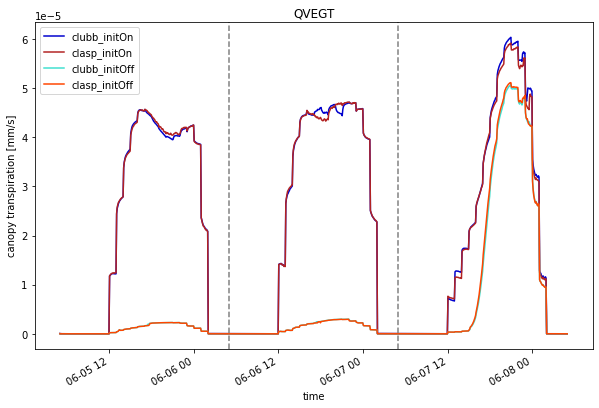

In [27]:
fig,axs=plt.subplots(1,1,figsize=(10,6))

varSel = 'QVEGT'

colorSel = ['mediumblue','firebrick','turquoise','orangered']

for iCase in range(len(allCLM_h0.case.values)):
    allCLM_h0.isel(case=iCase)[varSel].plot(color=colorSel[iCase],
                                            label=allCLM_h0.case.values[iCase])
    
# allCLM_h0_testDt[varSel].sel(case='clubb_initOn_regDt').plot(color='dodgerblue', label='clubb_initOn_regDt', linestyle='--')
# allCLM_h0_testDt[varSel].sel(case='clasp_initOn_regDt').plot(color='deeppink', label='clasp_initOn_regDt', linestyle='--')

axs.legend()
axs.set_title(varSel)

axs.axvline(allCLM_h0.time.values[0]+np.timedelta64(1,'D'), linestyle='--',color='grey')
axs.axvline(allCLM_h0.time.values[0]+np.timedelta64(2,'D'), linestyle='--',color='grey')


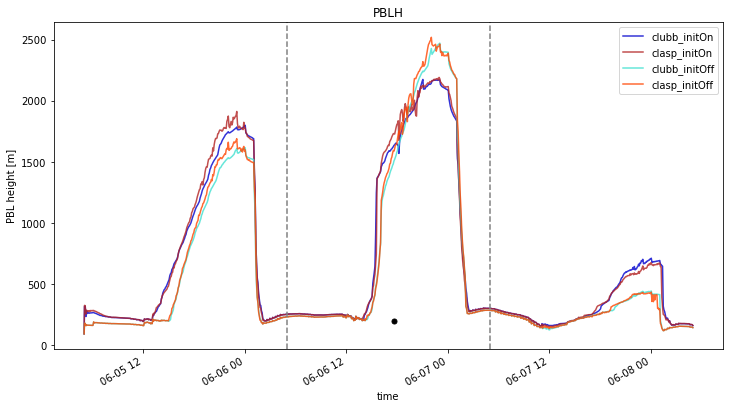

In [10]:
fig,axs=plt.subplots(1,1,figsize=(12,6))

varSel = 'PBLH'

colorSel = ['mediumblue','firebrick','turquoise','orangered','gold']

for iCase in range(len(all_h0.case.values)):
    all_h0.isel(case=iCase,lon=0,lat=0)[varSel].plot(color=colorSel[iCase],
                                        label=allCLM_h0.case.values[iCase], alpha=0.8)
    
# all_h0_testDt[varSel].sel(case='clubb_initOn_regDt').isel(lon=0,lat=0).plot(color='dodgerblue', label='clubb_initOn_regDt', linestyle='--')
# all_h0_testDt[varSel].sel(case='clasp_initOn_regDt').isel(lon=0,lat=0).plot(color='deeppink', label='clasp_initOn_regDt', linestyle='--')

axs.legend()
axs.set_title(varSel)

axs.axvline(all_h0.time.values[0]+np.timedelta64(1,'D'), linestyle='--',color='grey')
axs.axvline(all_h0.time.values[0]+np.timedelta64(2,'D'), linestyle='--',color='grey')

axs.plot(all_h0.time.values[440],200,'ko',markersize=5)


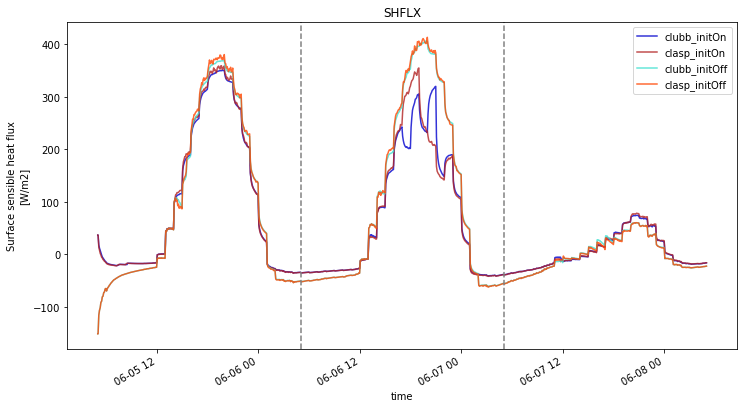

In [11]:
fig,axs=plt.subplots(1,1,figsize=(12,6))

varSel = 'SHFLX'

colorSel = ['mediumblue','firebrick','turquoise','orangered']

for iCase in range(len(all_h0.case.values)):
    all_h0.isel(case=iCase,lon=0,lat=0)[varSel].plot(color=colorSel[iCase],
                                            label=allCLM_h0.case.values[iCase], alpha=0.8)
    
# all_h0_testDt[varSel].sel(case='clubb_initOn_regDt').isel(lon=0,lat=0).plot(color='dodgerblue', label='clubb_initOn_regDt', linestyle='--')
# all_h0_testDt[varSel].sel(case='clasp_initOn_regDt').isel(lon=0,lat=0).plot(color='deeppink', label='clasp_initOn_regDt', linestyle='--')

axs.legend()
axs.set_title(varSel)

axs.axvline(all_h0.time.values[0]+np.timedelta64(1,'D'), linestyle='--',color='grey')
axs.axvline(all_h0.time.values[0]+np.timedelta64(2,'D'), linestyle='--',color='grey')


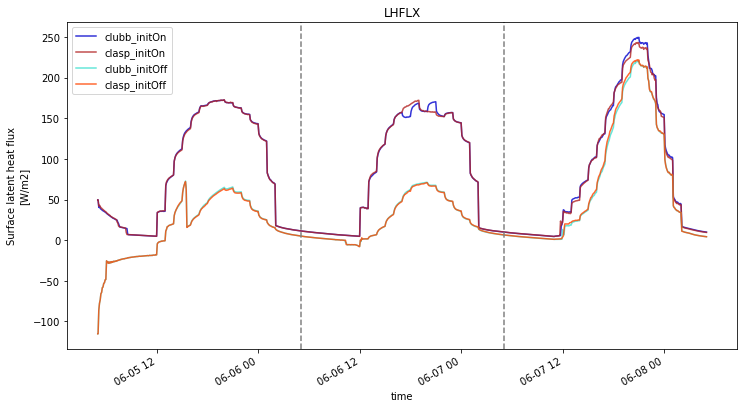

In [12]:
fig,axs=plt.subplots(1,1,figsize=(12,6))

varSel = 'LHFLX'

colorSel = ['mediumblue','firebrick','turquoise','orangered']

for iCase in range(len(all_h0.case.values)):
    all_h0.isel(case=iCase,lon=0,lat=0)[varSel].plot(color=colorSel[iCase],
                                            label=allCLM_h0.case.values[iCase], alpha=0.8)
    
# all_h0_testDt[varSel].sel(case='clubb_initOn_regDt').isel(lon=0,lat=0).plot(color='dodgerblue', label='clubb_initOn_regDt', linestyle='--')
# all_h0_testDt[varSel].sel(case='clasp_initOn_regDt').isel(lon=0,lat=0).plot(color='deeppink', label='clasp_initOn_regDt', linestyle='--')

axs.legend()
axs.set_title(varSel)

axs.axvline(all_h0.time.values[0]+np.timedelta64(1,'D'), linestyle='--',color='grey')
axs.axvline(all_h0.time.values[0]+np.timedelta64(2,'D'), linestyle='--',color='grey')


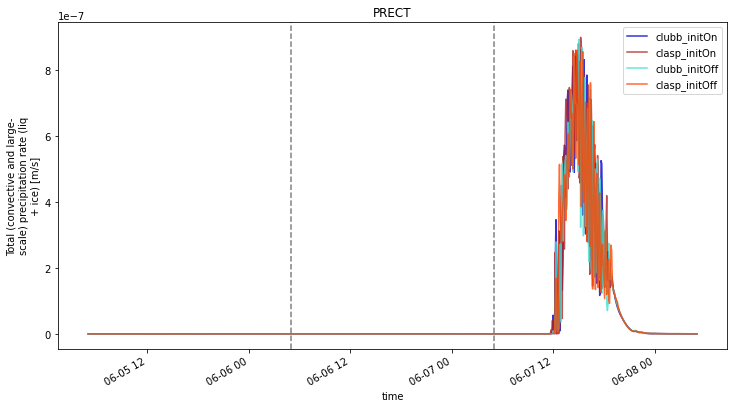

In [25]:
fig,axs=plt.subplots(1,1,figsize=(12,6))

varSel = 'PRECT'

colorSel = ['mediumblue','firebrick','turquoise','orangered']

for iCase in range(len(all_h0.case.values)):
    all_h0.isel(case=iCase,lon=0,lat=0)[varSel].plot(color=colorSel[iCase],
                                            label=allCLM_h0.case.values[iCase], alpha=0.8)
    
# all_h0_testDt[varSel].sel(case='clubb_initOn_regDt').isel(lon=0,lat=0).plot(color='dodgerblue', label='clubb_initOn_regDt', linestyle='--')
# all_h0_testDt[varSel].sel(case='clasp_initOn_regDt').isel(lon=0,lat=0).plot(color='deeppink', label='clasp_initOn_regDt', linestyle='--')

axs.legend()
axs.set_title(varSel)

axs.axvline(all_h0.time.values[0]+np.timedelta64(1,'D'), linestyle='--',color='grey')
axs.axvline(all_h0.time.values[0]+np.timedelta64(2,'D'), linestyle='--',color='grey')


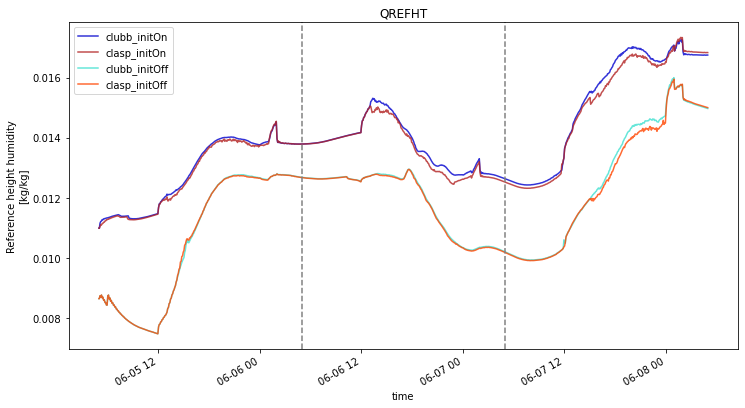

In [19]:
fig,axs=plt.subplots(1,1,figsize=(12,6))

varSel = 'QREFHT'

colorSel = ['mediumblue','firebrick','turquoise','orangered']

for iCase in range(len(all_h0.case.values)):
    all_h0.isel(case=iCase,lon=0,lat=0)[varSel].plot(color=colorSel[iCase],
                                            label=allCLM_h0.case.values[iCase], alpha=0.8)
    
# all_h0_testDt[varSel].sel(case='clubb_initOn_regDt').isel(lon=0,lat=0).plot(color='dodgerblue', label='clubb_initOn_regDt', linestyle='--')
# all_h0_testDt[varSel].sel(case='clasp_initOn_regDt').isel(lon=0,lat=0).plot(color='deeppink', label='clasp_initOn_regDt', linestyle='--')

axs.legend()
axs.set_title(varSel)

axs.axvline(all_h0.time.values[0]+np.timedelta64(1,'D'), linestyle='--',color='grey')
axs.axvline(all_h0.time.values[0]+np.timedelta64(2,'D'), linestyle='--',color='grey')


In [12]:
all_h3_testDt.thlu_macmic1

<xarray.DataArray 'thlu_macmic1' (case: 2, time: 217, ncyc: 2, nens: 10, ilev: 59, lat: 1, lon: 1)>
array([[[[[[[  0.     ]],

           [[  0.     ]],

           [[  0.     ]],

           ...,

           [[  0.     ]],

           [[  0.     ]],

           [[  0.     ]]],


          [[[  0.     ]],

           [[  0.     ]],

           [[  0.     ]],
...
           [[  0.     ]],

           [[  0.     ]],

           [[302.28125]]],


          [[[  0.     ]],

           [[  0.     ]],

           [[  0.     ]],

           ...,

           [[  0.     ]],

           [[  0.     ]],

           [[302.29056]]]]]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 36.6
  * lon      (lon) float64 262.5
  * ilev     (ilev) float64 2.055 3.98 6.909 11.27 ... 979.0 987.4 995.1 1e+03
  * time     (time) datetime64[ns] 2018-06-05T05:01:00 ... 2018-06-08T04:51:00
  * nens     (nens) int64 0 1 2 3 4 5 6 7 8 9
  * case     (case) object 'clubb_initOn_regDt' 'clasp_initOn_regDt'
Dimensions without coordinates: ncyc
Attributes:
    mdims:      [2 4 3]
    units:      m/s
    long_name:  thl up

In [39]:
all_h3_testDt

<xarray.Dataset>
Dimensions:       (case: 2, ilev: 59, lat: 1, lev: 58, lon: 1, nbnd: 2, ncyc: 2, nens: 10, time: 217)
Coordinates:
  * lat           (lat) float64 36.6
  * lon           (lon) float64 262.5
  * lev           (lev) float64 3.018 5.445 9.087 14.25 ... 983.2 991.2 997.5
  * ilev          (ilev) float64 2.055 3.98 6.909 11.27 ... 987.4 995.1 1e+03
  * time          (time) datetime64[ns] 2018-06-05T05:01:00 ... 2018-06-08T04...
  * nens          (nens) int64 0 1 2 3 4 5 6 7 8 9
  * case          (case) object 'clubb_initOn_regDt' 'clasp_initOn_regDt'
Dimensions without coordinates: nbnd, ncyc
Data variables:
    ntrk          (case) int32 1 1
    ntrn          (case) int32 1 1
    ntrm          (case) int32 1 1
    gw            (case, lat) float64 2.0 2.0
    hyam          (case, lev) float64 0.003018 0.005445 ... 0.0003615 0.0
    hybm          (case, lev) float64 0.0 0.0 0.0 0.0 ... 0.9821 0.9908 0.9975
    P0            (case) float64 1e+05 1e+05
    hyai          (case, ilev) float64 0.002055 0.00398 0.006909 ... 0.0 0.0
    hybi          (case, ilev) float64 0.0 0.0 0.0 0.0 ... 0.9866 0.9951 1.0
    date          (case, time) int32 20180605 20180605 ... 20180608 20180608
    datesec       (case, time) int32 18060 19260 20460 ... 15660 16860 18060
    time_bnds     (case, time, nbnd) object 2018-06-05 05:01:00 ... 2018-06-0...
    date_written  (case, time) |S8 b'02/28/23' b'02/28/23' ... b'02/28/23'
    time_written  (case, time) |S8 b'09:10:12' b'09:10:12' ... b'08:46:48'
    ndbase        (case) int32 0 0
    nsbase        (case) int32 0 0
    nbdate        (case) int32 20180605 20180605
    nbsec         (case) int32 18060 18060
    mdt           (case) int32 1200 1200
    ndcur         (case, time) int32 0 0 0 0 0 0 0 0 0 0 ... 2 2 2 2 2 2 2 2 2 3
    nscur         (case, time) int32 0 1200 2400 3600 ... 82800 84000 85200 0
    co2vmr        (case, time) float64 0.0003725 0.0003725 ... 0.0003722
    ch4vmr        (case, time) float64 1.841e-06 1.841e-06 ... 1.84e-06 1.84e-06
    n2ovmr        (case, time) float64 3.159e-07 3.159e-07 ... 3.159e-07
    f11vmr        (case, time) float64 7.087e-10 7.087e-10 ... 7.086e-10
    f12vmr        (case, time) float64 5.413e-10 5.413e-10 ... 5.413e-10
    sol_tsi       (case, time) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
    nsteph        (case, time) int32 0 1 2 3 4 5 6 ... 211 212 213 214 215 216
    qtd_macmic1   (case, time, ncyc, nens, ilev, lat, lon) float32 0.0 ... 0.0
    qtd_macmic2   (case, time, ncyc, nens, ilev, lat, lon) float32 0.0 ... 0.0
    qtu_macmic1   (case, time, ncyc, nens, ilev, lat, lon) float32 0.0 ... 0....
    qtu_macmic2   (case, time, ncyc, nens, ilev, lat, lon) float32 0.0 ... 0....
    thld_macmic1  (case, time, ncyc, nens, ilev, lat, lon) float32 0.0 ... 0.0
    thld_macmic2  (case, time, ncyc, nens, ilev, lat, lon) float32 0.0 ... 0.0
    thlu_macmic1  (case, time, ncyc, nens, ilev, lat, lon) float32 0.0 ... 302.3
    thlu_macmic2  (case, time, ncyc, nens, ilev, lat, lon) float32 0.0 ... 302.2
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataFALSE_se...
    logname:           mdfowler
    host:              izumi.cgd.ucar.e
    initial_file:      /project/amp/rneale/scam/ncar_pbl/ncdata/FWsc_T42_58L_...
    topography_file:   /fs/cgd/csm/inputdata/atm/cam/topo/T42_nc3000_Co060_Fi...
    model_doi_url:     not_set
    time_period_freq:  minute_20